In [1]:
# !pip install ezodf
# !pip install fancyimpute
# ! pip install kmodes
# !pip install gower
# !pip install pyod
# ! pip install hdbscan

In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ezodf
import gower

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import dendrogram, linkage

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import hdbscan

import torch
import torch.nn as nn
import torch.optim as optim

### Loading Input data (.ods file )

In [471]:
def read_ods_file(file_path, sheet_name=0):
    ezodf.config.set_table_expand_strategy('all')
    spreadsheet = ezodf.opendoc(file_path)
    sheet = spreadsheet.sheets[sheet_name]

    data = []
    for row in sheet.rows():
        row_data = [cell.value for cell in row]
        data.append(row_data)
    df = pd.DataFrame(data[1:], columns=data[0])
    
    return df

file_path = '../data/Machine Learning Challenge.ods'
raw_data = read_ods_file(file_path, sheet_name=0)
raw_data.head()

,consumer_id,gender,has_gender,has_first_name,has_last_name,has_email,has_dob,customer_age,account_age,account_last_updated,account_status,app_downloads,unique_offer_clicked,total_offer_clicks,unique_offer_impressions,total_offer_impressions,avg_redemptions,min_redemptions,max_redemptions,total_offers_redeemed
0,1284b75c-ecae-4015-8e3d-359c0347ede8,None,0.0,1.0,1.0,1.0,0.0,NaN,188.0,174.0,0.0,1.0,3.0,3.0,8.0,52.0,1.0,1.0,1.0,1.0
1,128af162-d2c3-4fe4-986c-359c8bdc6c04,None,0.0,1.0,1.0,1.0,0.0,NaN,185.0,174.0,0.0,1.0,3.0,8.0,5.0,58.0,1.0,1.0,1.0,1.0
2,12aada5e-36eb-4e9e-8d62-359c076c1b40,None,0.0,1.0,1.0,1.0,0.0,NaN,188.0,174.0,0.0,1.0,3.0,4.0,9.0,183.0,1.0,1.0,1.0,3.0
3,12c2e02f-bc79-4048-83ba-359cd3280dcf,None,0.0,1.0,1.0,1.0,0.0,NaN,184.0,174.0,0.0,1.0,3.0,7.0,4.0,56.0,1.0,1.0,1.0,1.0
4,12fabdf0-0582-489e-a6d3-35509ab8ae6f,f,1.0,1.0,1.0,1.0,1.0,22.0,572.0,173.0,0.0,1.0,4.0,6.0,7.0,83.0,1.0,1.0,1.0,3.0


In [566]:
raw_data.columns

Index(['consumer_id', 'gender', 'has_gender', 'has_first_name',
       'has_last_name', 'has_email', 'has_dob', 'customer_age', 'account_age',
       'account_last_updated', 'account_status', 'app_downloads',
       'unique_offer_clicked', 'total_offer_clicks',
       'unique_offer_impressions', 'total_offer_impressions',
       'avg_redemptions', 'min_redemptions', 'max_redemptions',
       'total_offers_redeemed'],
      dtype='object')

## Data Pre-processing - Feature Engineering

#### 1.) Removed `consumer_id` and `account_status`
* Consumer ID is a unique identifier and doesn’t offer any predictive power for anomaly detection or segmentation.
* Account Status has a constant value (0), so it provides no variation or information to the model. Features with no variance are redundant for most machine learning models, as they don't help in distinguishing between different data points.

#### 2.) Duplicate removal: 
* Identified and removed 388 duplicate rows and no duplicate columns found. Duplicates can skew the results of any model as they may lead to overfitting. Removing duplicates helps maintain the integrity of the data.


In [474]:
df = raw_data.copy()
df = df.drop(['consumer_id', 'account_status'], axis=1) 

# Find duplicate rows and remove them
duplicate_rows = df[df.duplicated()]
print(f"Number of Duplicate Rows:\t{len(duplicate_rows)}")
df_no_duplicate_rows = df.drop_duplicates(keep='first')

# Find duplicate columns and remove them
df_T = df_no_duplicate_rows.T
duplicate_cols = df_T[df_T.duplicated()]
print(f"Number of Duplicate Columns:\t{len(duplicate_cols)}")
df_no_duplicates = df_T.drop_duplicates(keep='first').T

print("DataFrame after removing duplicate rows and columns:\t", df_no_duplicates.shape)

index_no_duplicates = df_no_duplicates.index
df = df_no_duplicates.reset_index(drop=True).copy()

Number of Duplicate Rows:	388
Number of Duplicate Columns:	0
DataFrame after removing duplicate rows and columns:	 (9612, 18)


In [476]:
df_no_duplicates.head()

,gender,has_gender,has_first_name,has_last_name,has_email,has_dob,customer_age,account_age,account_last_updated,app_downloads,unique_offer_clicked,total_offer_clicks,unique_offer_impressions,total_offer_impressions,avg_redemptions,min_redemptions,max_redemptions,total_offers_redeemed
0,None,0.0,1.0,1.0,1.0,0.0,NaN,188.0,174.0,1.0,3.0,3.0,8.0,52.0,1.0,1.0,1.0,1.0
1,None,0.0,1.0,1.0,1.0,0.0,NaN,185.0,174.0,1.0,3.0,8.0,5.0,58.0,1.0,1.0,1.0,1.0
2,None,0.0,1.0,1.0,1.0,0.0,NaN,188.0,174.0,1.0,3.0,4.0,9.0,183.0,1.0,1.0,1.0,3.0
3,None,0.0,1.0,1.0,1.0,0.0,NaN,184.0,174.0,1.0,3.0,7.0,4.0,56.0,1.0,1.0,1.0,1.0
4,f,1.0,1.0,1.0,1.0,1.0,22.0,572.0,173.0,1.0,4.0,6.0,7.0,83.0,1.0,1.0,1.0,3.0


#### 3.) Missing Value Imputation: 
* Missing data in critical features like gender and customer_age can affect model performance. These missing values were nearly 50% of the dataset, so dropping them would result in significant data loss.
    - **KNN Imputation:** This method replaces missing values based on the values of similar rows, preserving local patterns by voting or average.
    - **MICE Imputation:** This iterative method uses multiple regression models to impute missing values by using other features in the dataset. MICE worked better because it captures complex relationships between features and provides a more robust estimation for missing values.
 
*Out of the two methods imputation with MICE worked better as it doen't affect the initial distribution of the features*

In [478]:
# list the number of missing values for each column
df.isnull().sum()

gender                      4160
has_gender                     0
has_first_name                 0
has_last_name                  0
has_email                      0
has_dob                        0
customer_age                5558
account_age                    0
account_last_updated           0
app_downloads                  0
unique_offer_clicked           0
total_offer_clicks             0
unique_offer_impressions       0
total_offer_impressions        0
avg_redemptions                0
min_redemptions                0
max_redemptions                0
total_offers_redeemed          0
dtype: int64

In [480]:
le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])
df['gender'] = df['gender'].replace(2, np.nan)

In [482]:
# 1. KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = df.copy()
df_knn[['gender', 'customer_age']] = knn_imputer.fit_transform(df_knn[['gender', 'customer_age']])
df_knn['gender'] = df_knn['gender'].apply(round)

# 2. MICE Imputation
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
df_mice = df.copy()
df_mice[['gender', 'customer_age']] = mice_imputer.fit_transform(df_mice[['gender', 'customer_age']])
df_mice['gender'] = df_mice['gender'].apply(round)

In [483]:
df['customer_age'].isna().sum()

5558

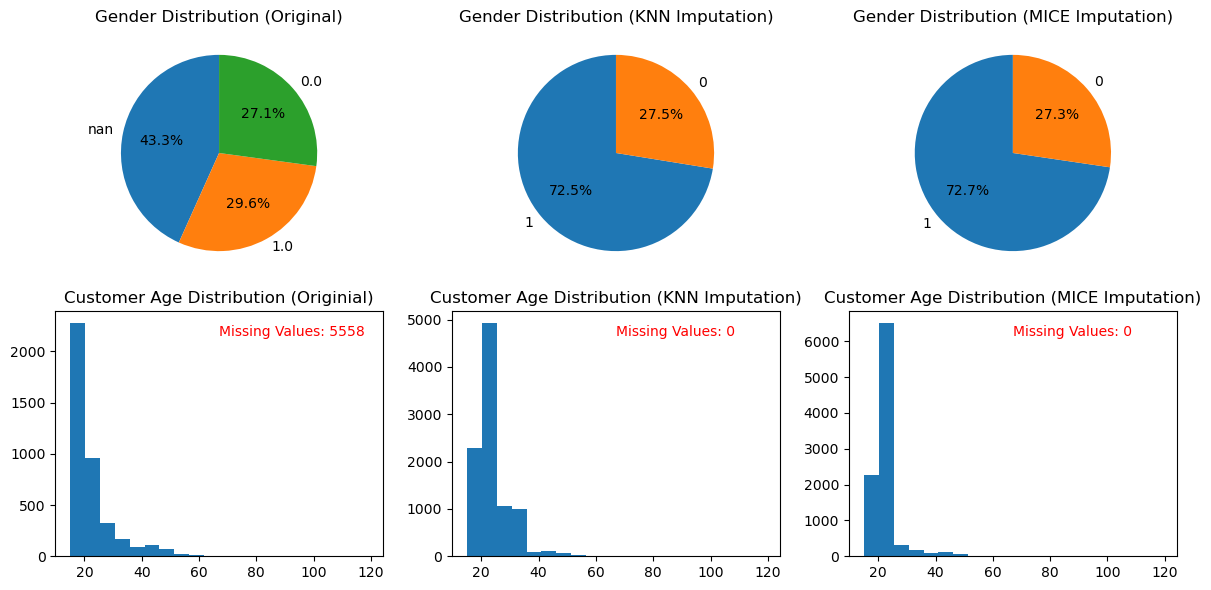

In [486]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Pie chart for gender in df
df_gender_counts = df['gender'].value_counts(dropna=False)
axes[0, 0].pie(df_gender_counts, labels=df_gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Gender Distribution (Original)')

# Pie chart for gender in df_knn
df_knn_gender_counts = df_knn['gender'].value_counts(dropna=False)
axes[0, 1].pie(df_knn_gender_counts, labels=df_knn_gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Gender Distribution (KNN Imputation)')

# Pie chart for gender in df_mice
df_mice_gender_counts = df_mice['gender'].value_counts(dropna=False)
axes[0, 2].pie(df_mice_gender_counts, labels=df_mice_gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Gender Distribution (MICE Imputation)')

# Histogram for customer_age in df
axes[1, 0].hist(df['customer_age'], bins=20)
axes[1, 0].set_title('Customer Age Distribution (Originial)')
axes[1, 0].text(0.5, 0.9, f'Missing Values: {df["customer_age"].isnull().sum()}', transform=axes[1, 0].transAxes, color='red')

# Histogram for customer_age in df_knn
axes[1, 1].hist(df_knn['customer_age'], bins=20)
axes[1, 1].set_title('Customer Age Distribution (KNN Imputation)')
axes[1, 1].text(0.5, 0.9, f'Missing Values: {df_knn["customer_age"].isnull().sum()}', transform=axes[1, 1].transAxes, color='red')

# Histogram for customer_age in df_mice
axes[1, 2].hist(df_mice['customer_age'], bins=20)
axes[1, 2].set_title('Customer Age Distribution (MICE Imputation)')
axes[1, 2].text(0.5, 0.9, f'Missing Values: {df_mice["customer_age"].isnull().sum()}', transform=axes[1, 2].transAxes, color='red')

plt.tight_layout()
plt.show()

#### 4.) Feature Construction
**4.1 Created new features:** Features like `ctr` (click-through-rate), `redemption_rate`, `unique_offer_rate`
These new features provide a more meaningful representation than absolute values for customer engagement and are essential for both anomaly detection and segmentation. 

**4.2 Log Transformation:** Many numerical features (`like account_age`, `total_offer_clicks`) are representing skewed distributions in the dataset. Log transformation reduces skewness, making these features more normally distributed, which improves the performance of machine learning models, especially for clustering.

**4.3 Clustering with K-Modes:** 
* The `demographic_cluster` and `redemption_cluster` features capture patterns in extremely distributed categorical features. K-Modes is effective for clustering categorical features because it uses dissimilarity based on the mode rather than the mean. 
* I combined, demographic features and redemption based features and created two new features using `K-Modes clustering` algorithm(the features are categorical representations). This clustering provides additional insight into how demographic or redemption behaviors group customers together.

**4.4 Cardinality Reduction:**
Feature `app_downloads` has 5 distinct values with one dominat category. The traditional `One-Hot Encoding` will increase the dimensionality and add less relevant features to then model(majaority of the values will be 0). To overcome these issues, except the majority category, remain are grouped into one class.

In [488]:
#  Feature Construction - Ratio based variables
df_mice['ctr'] = df_mice['total_offer_clicks'] / df_mice['total_offer_impressions']
df_mice['redemption_rate'] = df_mice['total_offers_redeemed'] / df_mice['total_offer_clicks']
df_mice['unique_offer_ctr'] = df_mice['unique_offer_clicked'] / df_mice['unique_offer_impressions']

# Cardinality reduction
df_mice['app_downloads'] = df_mice['app_downloads'].apply(lambda x: 1 if x == 1 else 0)

# Log transformation
cols_to_log_transform = ['customer_age', 'account_age', 'total_offer_clicks', 
            'account_last_updated', 'total_offer_impressions', 'total_offer_clicks', 
            'total_offers_redeemed', 'unique_offer_clicked', 'unique_offer_impressions']

for col in cols_to_log_transform:
  df_mice[col] = pd.to_numeric(df_mice[col], errors='coerce')
  df_mice[f'log_{col}'] = np.log(df_mice[col] + 1)

print(df_mice.shape)

(9612, 29)


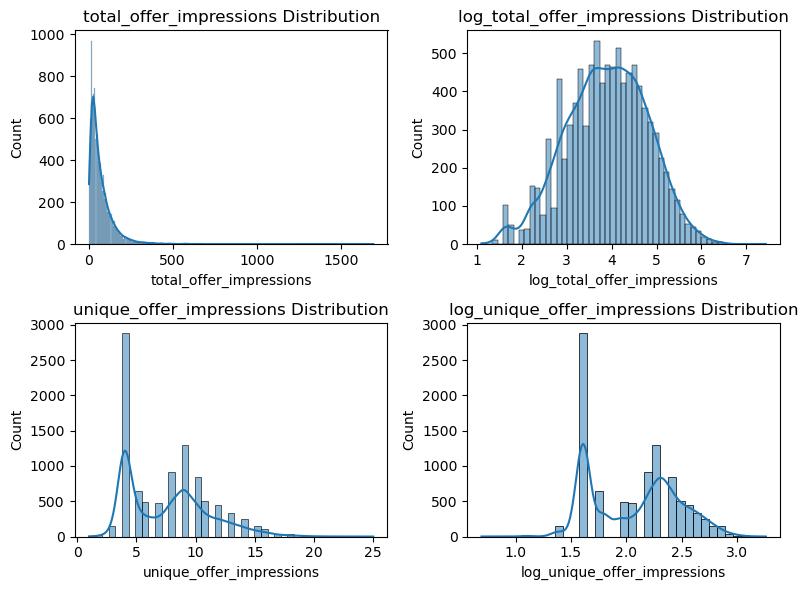

In [489]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Select variables for comparison
variables = ['total_offer_impressions', 'unique_offer_impressions']

for i, variable in enumerate(variables):
    sns.histplot(df_mice[variable], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{variable} Distribution')

    sns.histplot(df_mice[f'log_{variable}'], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'log_{variable} Distribution')

plt.tight_layout()
plt.show()

In [492]:
df_mice = df_mice.drop(cols_to_log_transform, axis=1)
df_mice.shape

(9612, 21)

In [494]:
df_mice.head()

,gender,has_gender,has_first_name,has_last_name,has_email,has_dob,app_downloads,avg_redemptions,min_redemptions,max_redemptions,...,redemption_rate,unique_offer_ctr,log_customer_age,log_account_age,log_total_offer_clicks,log_account_last_updated,log_total_offer_impressions,log_total_offers_redeemed,log_unique_offer_clicked,log_unique_offer_impressions
0,1,0.0,1.0,1.0,1.0,0.0,1,1.0,1.0,1.0,...,0.333333,0.375,3.177741,5.241747,1.386294,5.164786,3.970292,0.693147,1.386294,2.197225
1,1,0.0,1.0,1.0,1.0,0.0,1,1.0,1.0,1.0,...,0.125,0.6,3.177741,5.225747,2.197225,5.164786,4.077537,0.693147,1.386294,1.791759
2,1,0.0,1.0,1.0,1.0,0.0,1,1.0,1.0,1.0,...,0.75,0.333333,3.177741,5.241747,1.609438,5.164786,5.214936,1.386294,1.386294,2.302585
3,1,0.0,1.0,1.0,1.0,0.0,1,1.0,1.0,1.0,...,0.142857,0.75,3.177741,5.220356,2.079442,5.164786,4.043051,0.693147,1.386294,1.609438
4,0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,...,0.5,0.571429,3.135494,6.350886,1.945910,5.159055,4.430817,1.386294,1.609438,2.079442


In [496]:
## Handling extreme values - Feature construction with Clustering
##  - group similar variables into meaningful cluster 
##  - this strategy eliminates the extreme unbalance in the features.
has_columns = [col for col in df_mice.columns if col.startswith('has_')]
redemption_columns = [col for col in df_mice.columns if 'redemptions' in col]

# Create Demographic cluster feature: K-Modes Clustering for 'has_' columns
kmodes_has = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)
df_mice['demographic_cluster'] = kmodes_has.fit_predict(df_mice[has_columns])

# Create Redemption cluster feature: K-Modes Clustering for 'redemption' columns
kmodes_redemption = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)
df_mice['redemption_cluster'] = kmodes_redemption.fit_predict(df_mice[redemption_columns])

# processed_data = df_mice.drop(has_columns + redemption_columns,axis=1)
# processed_data.shape

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1837.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1584, cost: 1837.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1837.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 7909.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1584, cost: 1837.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37, cost: 52.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 37, cost: 52.0
Init: initializing centroids
Init: initializing clusters
Starting iterations..

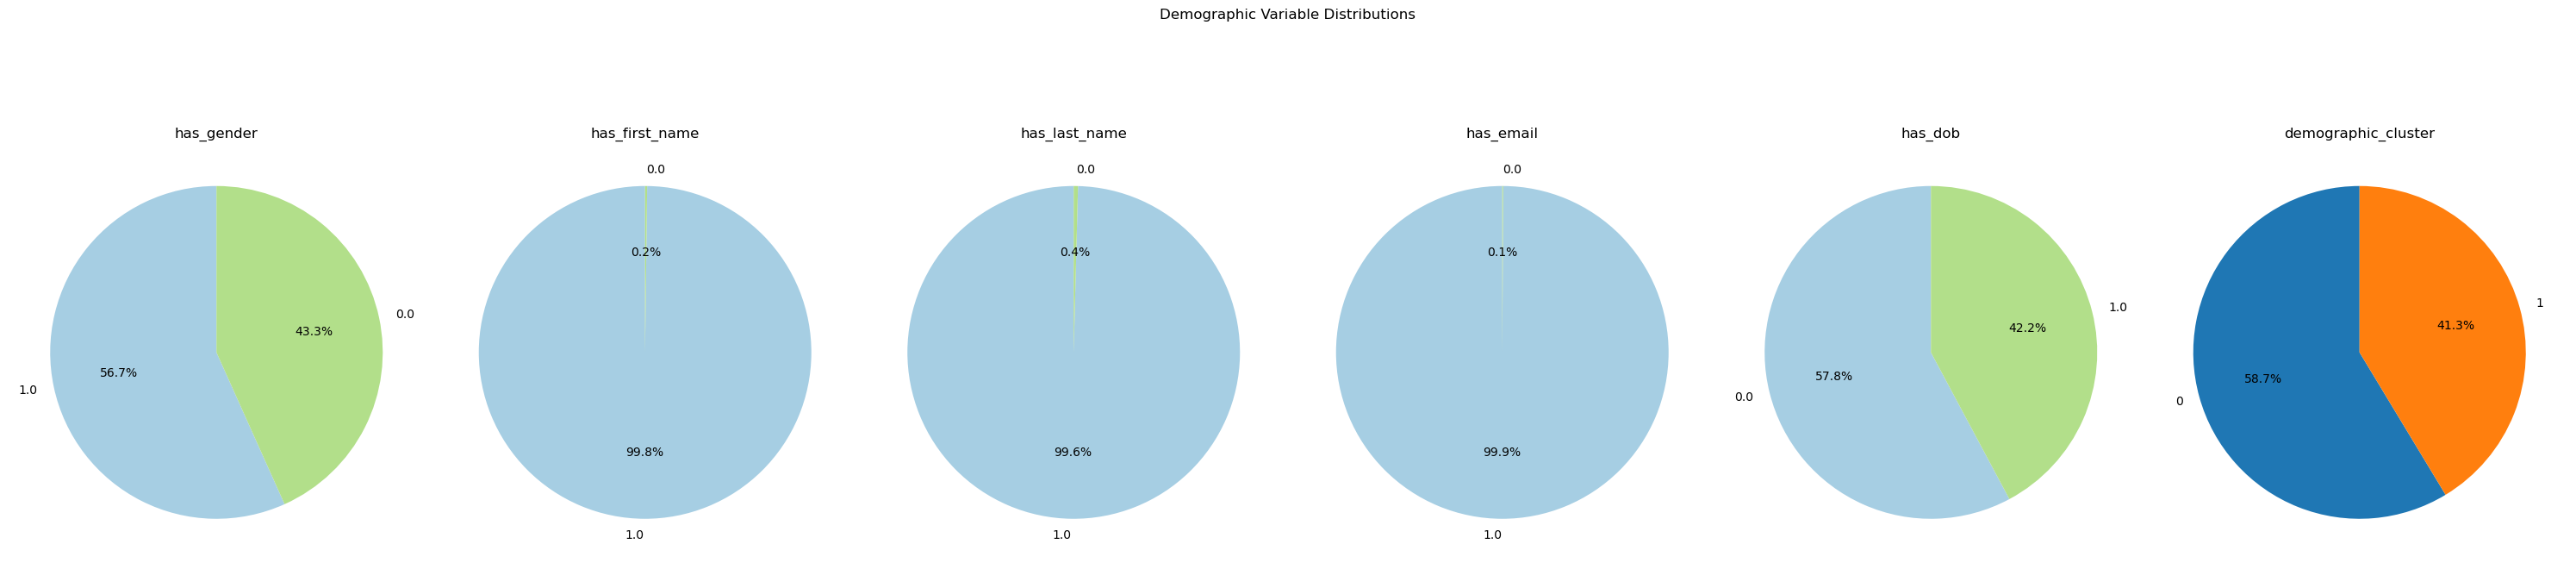

In [498]:
def create_pie_charts(df, columns, color_palette):
  num_cols = len(columns)
  fig, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 8))
  fig.suptitle(f"Demographic Variable Distributions")

  for i, col in enumerate(columns):
    df_counts = df[col].value_counts(dropna=False)
    if col == 'demographic_cluster':
      axes[i].pie(df_counts, labels=df_counts.index, autopct='%1.1f%%', startangle=90)
    else:
      axes[i].pie(df_counts, labels=df_counts.index, autopct='%1.1f%%', startangle=90, colors=color_palette)
    axes[i].set_title(f'{col}')

  plt.tight_layout()
  plt.show()


# Create pie charts for 'has_' columns including 'has_cluster'
has_columns_with_cluster = has_columns + ['demographic_cluster']
create_pie_charts(df_mice, has_columns_with_cluster, plt.cm.Paired(np.linspace(0, 1, len(has_columns_with_cluster))))  # Use a color palette for clusters

In [500]:
processed_data = df_mice.drop([i for i in has_columns if i not in  ['has_gender', 'has_dob']] + redemption_columns, axis=1)
processed_data.shape

(9612, 17)

In [502]:
processed_data.head()

,gender,has_gender,has_dob,app_downloads,ctr,redemption_rate,unique_offer_ctr,log_customer_age,log_account_age,log_total_offer_clicks,log_account_last_updated,log_total_offer_impressions,log_total_offers_redeemed,log_unique_offer_clicked,log_unique_offer_impressions,demographic_cluster,redemption_cluster
0,1,0.0,0.0,1,0.057692,0.333333,0.375,3.177741,5.241747,1.386294,5.164786,3.970292,0.693147,1.386294,2.197225,1,0
1,1,0.0,0.0,1,0.137931,0.125,0.6,3.177741,5.225747,2.197225,5.164786,4.077537,0.693147,1.386294,1.791759,1,0
2,1,0.0,0.0,1,0.021858,0.75,0.333333,3.177741,5.241747,1.609438,5.164786,5.214936,1.386294,1.386294,2.302585,1,0
3,1,0.0,0.0,1,0.125,0.142857,0.75,3.177741,5.220356,2.079442,5.164786,4.043051,0.693147,1.386294,1.609438,1,0
4,0,1.0,1.0,1,0.072289,0.5,0.571429,3.135494,6.350886,1.945910,5.159055,4.430817,1.386294,1.609438,2.079442,0,0


#### 5.) Normalization
* `Normalization` scales all numerical features to a range (e.g., 0 to 1), making the features comparable without changing the distribution of categorical encoded variables unlike `Standardization`. This is useful when you have features with different ranges or magnitudes.

In [504]:
scaler = MinMaxScaler()
numerical_columns = processed_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

processed_data[numerical_columns] = scaler.fit_transform(processed_data[numerical_columns])
processed_data.head()

,gender,has_gender,has_dob,app_downloads,ctr,redemption_rate,unique_offer_ctr,log_customer_age,log_account_age,log_total_offer_clicks,log_account_last_updated,log_total_offer_impressions,log_total_offers_redeemed,log_unique_offer_clicked,log_unique_offer_impressions,demographic_cluster,redemption_cluster
0,1.0,0.0,0.0,1.0,0.057692,0.333333,0.375,0.201078,0.058651,0.200913,0.074052,0.453215,0.000000,0.344010,0.586397,1,0
1,1.0,0.0,0.0,1.0,0.137931,0.125,0.6,0.201078,0.046457,0.435966,0.074052,0.470141,0.000000,0.344010,0.428317,1,0
2,1.0,0.0,0.0,1.0,0.021858,0.75,0.333333,0.201078,0.058651,0.265592,0.074052,0.649648,0.386853,0.344010,0.627474,1,0
3,1.0,0.0,0.0,1.0,0.125,0.142857,0.75,0.201078,0.042349,0.401826,0.074052,0.464698,0.000000,0.344010,0.357235,1,0
4,0.0,1.0,1.0,1.0,0.072289,0.5,0.571429,0.180111,0.903911,0.363121,0.000000,0.525897,0.386853,0.454757,0.540476,0,0


In [568]:
processed_data.columns

Index(['gender', 'has_gender', 'has_dob', 'app_downloads', 'ctr',
       'redemption_rate', 'unique_offer_ctr', 'log_customer_age',
       'log_account_age', 'log_total_offer_clicks', 'log_account_last_updated',
       'log_total_offer_impressions', 'log_total_offers_redeemed',
       'log_unique_offer_clicked', 'log_unique_offer_impressions',
       'demographic_cluster', 'redemption_cluster'],
      dtype='object')

#### 6.) Anomaly Detection
Applied five different anomaly detection methods on the processed data to identify outliers:
1. **Local Outlier Factor (LOF):** Detects local density deviations.
2. **Isolation Forest:** Detects anomalies by isolating instances.
3. **DBSCAN:** Density-based clustering that can identify anomalies as noise points.
4. **One-Class SVM:** Classifies anomalies based on decision boundaries.
5. **Autoencoders:** A neural network-based approach to detect anomalies by reconstruction errors.
  
**Justification:**
   - `LOF` and `DBSCAN` are *density-based* approaches that detect anomalies based on how isolated a point is relative to its neighbors. They work well for non-linear data distributions.
   - `Isolation Forest` and `One-Class SVM` are *distance-based* methods, which are effective when the data has clear distinctions between normal and anomalous points.
   - `Autoencoders` are deep learning models that capture complex relationships and detect anomalies based on *reconstruction errors*. This approach is useful when the dataset is large and contains non-linear patterns.

*By combining results from all these methods, you ensure a comprehensive approach to outlier detection, avoiding reliance on a single technique that may have limitations. **Additionally, if the time permits, the process can be extended to obtain the optimal performance of a model using hyper parameters tuning.***

In [300]:
# --- Local Outlier Factor (LOF) --- #
lof = LocalOutlierFactor()
lof_predictions = lof.fit_predict(processed_data)
lof_anomalies_indices = np.where(lof_predictions == -1)[0]

# --- Isolation Forest --- #
isf_clf = IsolationForest(contamination=len(lof_anomalies_indices)/processed_data.shape[0]) 
isf_clf.fit(processed_data)

isf_predictions = isf_clf.predict(processed_data)
isf_anomalies_indices = np.where(isf_predictions == -1)[0]

# --- DBSCAN --- #
dbscan = DBSCAN(eps=0.3, min_samples=3)
dbscan.fit(processed_data)

dbscan_predictions = dbscan.labels_
dbscan_anomalies_indices = np.where(dbscan_predictions == -1)[0]

# --- One-Class SVM --- #
ocsvm = OneClassSVM(nu=len(lof_anomalies_indices)/processed_data.shape[0], kernel="rbf")
ocsvm.fit(processed_data)
ocsvm_predictions = ocsvm.predict(processed_data)
ocsvm_anomalies_indices = np.where(ocsvm_predictions == -1)[0]

print(f"Local Outlier Factor (LOF): {len(lof_anomalies_indices)} anomalies detected")
print(f"Isolation Forest: {len(isf_anomalies_indices)} anomalies detected")
print(f"DBSCAN: {len(dbscan_anomalies_indices)} anomalies detected")
print(f"One-Class SVM: {len(ocsvm_anomalies_indices)} anomalies detected")

Local Outlier Factor (LOF): 586 anomalies detected
Isolation Forest: 586 anomalies detected
DBSCAN: 466 anomalies detected
One-Class SVM: 585 anomalies detected


In [302]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define Network parameters
input_dim = processed_data.shape[1]
encoding_dim = 6  
autoencoder = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

input_data = np.array(processed_data.values, dtype='float32')
data_tensor = torch.Tensor(input_data) # Convert to PyTorch tensors

# Train the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = autoencoder(data_tensor)
    loss = criterion(outputs, data_tensor)
    loss.backward()
    optimizer.step()

# Calculate reconstruction errors
reconstructed_data = autoencoder(data_tensor).detach().numpy()
reconstruction_errors = np.mean(np.square(processed_data.values - reconstructed_data), axis=1)

# Identify anomalies
threshold = np.percentile(reconstruction_errors, 95)
autoencoders_anomalies_indices = np.where(reconstruction_errors > threshold)[0]
# print("Detected anomalies:", anomalies_indices)
print(f"Autoencoders: {len(autoencoders_anomalies_indices)} anomalies detected")

Autoencoders: 481 anomalies detected


* Different models capture different types of anomalies (local, global, density-based). By combining them, you ensure that all relevant outliers are detected.
Removing anomalies ensures that segmentation is performed on clean data, allowing the model to capture true patterns in customer behavior without being affected by outliers.

#### 7.) Customer Segmentation
Performed customer segmentation using:

1. K-Prototypes: Captures mixed numerical and categorical features.
2. Gaussian Mixture Model (GMM): Probabilistic clustering method for mixed data type.
3. Hierarchical Clustering: Creates clusters in a hierarchy and visualizes via dendrogram.

    - Optimal cluster values determined using `Elbow method`, `BIC`, and `Dendrogram`.

**Justification:**

* K-Prototypes: Handles both categorical and numerical data, making it perfect for segmenting customer data with mixed feature types.
* GMM: A flexible probabilistic model that captures cluster shapes that aren’t necessarily spherical, unlike K-Means.
* Hierarchical Clustering: Useful for identifying customer groups at different levels of granularity and can be visualized through a dendrogram.
  
*The Elbow method helps find the point where adding more clusters doesn’t significantly improve model performance. BIC is used to penalize models that are too complex, and the dendrogram helps visually inspect the clustering hierarchy.*

In [506]:
all_anomalies = set(isf_anomalies_indices.tolist() + dbscan_anomalies_indices.tolist() + ocsvm_anomalies_indices.tolist() + 
                    lof_anomalies_indices.tolist() + autoencoders_anomalies_indices.tolist())
anomalies_data = processed_data.loc[list(all_anomalies),:]
anomalies_data["customer_group"] = -1
# df_no_anomalies = df_processed.drop(all_anomalies, axis=0)
len(all_anomalies)/ processed_data.shape[0]

0.14346650020807325

In [508]:
df_no_anomalies = processed_data.drop(all_anomalies, axis=0)
df_no_anomalies.shape

(8233, 17)

In [510]:
df_no_anomalies.head()

,gender,has_gender,has_dob,app_downloads,ctr,redemption_rate,unique_offer_ctr,log_customer_age,log_account_age,log_total_offer_clicks,log_account_last_updated,log_total_offer_impressions,log_total_offers_redeemed,log_unique_offer_clicked,log_unique_offer_impressions,demographic_cluster,redemption_cluster
0,1.0,0.0,0.0,1.0,0.057692,0.333333,0.375,0.201078,0.058651,0.200913,0.074052,0.453215,0.000000,0.344010,0.586397,1,0
1,1.0,0.0,0.0,1.0,0.137931,0.125,0.6,0.201078,0.046457,0.435966,0.074052,0.470141,0.000000,0.344010,0.428317,1,0
2,1.0,0.0,0.0,1.0,0.021858,0.75,0.333333,0.201078,0.058651,0.265592,0.074052,0.649648,0.386853,0.344010,0.627474,1,0
3,1.0,0.0,0.0,1.0,0.125,0.142857,0.75,0.201078,0.042349,0.401826,0.074052,0.464698,0.000000,0.344010,0.357235,1,0
4,0.0,1.0,1.0,1.0,0.072289,0.5,0.571429,0.180111,0.903911,0.363121,0.000000,0.525897,0.386853,0.454757,0.540476,0,0


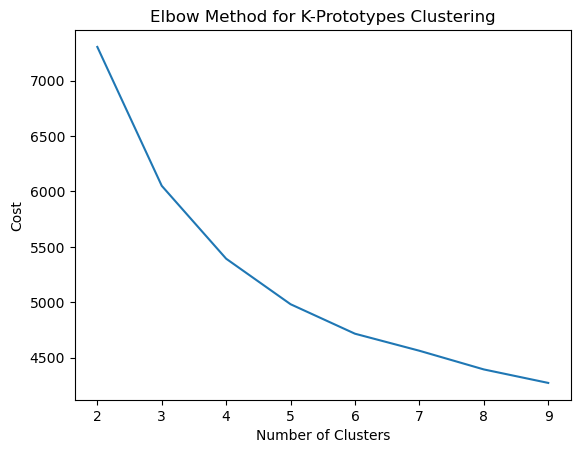

In [524]:
# Select categorical and numerical columns
categorical_columns = ['gender', 'has_gender', 'has_dob', 'app_downloads', 'demographic_cluster', 'redemption_cluster']
numerical_columns = [i for i in processed_data.columns if i not in categorical_columns]
columns_for_kproto = numerical_columns + categorical_columns

# Convert categorical columns to the appropriate type
df_kproto = df_no_anomalies.copy()
df_kproto[categorical_columns] = df_kproto[categorical_columns].astype('category')

# Finding optimal number of clusters using the Elbow method (cost function)
cost = []
for num_clusters in range(2, 10):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', n_init=10, verbose=0)
    kproto.fit(df_kproto[columns_for_kproto], categorical=[df_kproto.columns.get_loc(col) for col in categorical_columns])
    cost.append(kproto.cost_)

# Plot the cost to find the elbow point
plt.plot(range(2, 10), cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for K-Prototypes Clustering')
plt.show()

In [526]:
# Now apply K-Prototypes with the optimal number of clusters (determine from the elbow plot)
optimal_clusters_kproto = 4
kproto = KPrototypes(n_clusters=optimal_clusters_kproto, init='Huang', n_init=10, verbose=1)
df_kproto['customer_group'] = kproto.fit_predict(df_kproto[columns_for_kproto], categorical=[df_kproto.columns.get_loc(col) for col in categorical_columns])
kproto_result_df = pd.concat([df_kproto, anomalies_data], axis=0)
kproto_result_df['customer_group'].value_counts()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1500, ncost: 5824.80839312213
Run: 1, iteration: 2/100, moves: 567, ncost: 5788.570726564987
Run: 1, iteration: 3/100, moves: 249, ncost: 5783.289587571186
Run: 1, iteration: 4/100, moves: 105, ncost: 5782.34286561599
Run: 1, iteration: 5/100, moves: 37, ncost: 5782.235056023936
Run: 1, iteration: 6/100, moves: 8, ncost: 5782.228249205211
Run: 1, iteration: 7/100, moves: 3, ncost: 5782.227403890017
Run: 1, iteration: 8/100, moves: 0, ncost: 5782.227403890017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 354, ncost: 5840.967045119775
Run: 2, iteration: 2/100, moves: 14, ncost: 5840.851851692296
Run: 2, iteration: 3/100, moves: 3, ncost: 5840.845973399702
Run: 2, iteration: 4/100, moves: 0, ncost: 5840.845973399702
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration

customer_group
 2    3439
 0    1833
 3    1617
-1    1379
 1    1344
Name: count, dtype: int64

In [534]:
kproto_result_df['customer_group'].value_counts()
# df_kproto.shape

customer_group
 2    3439
 0    1833
 3    1617
-1    1379
 1    1344
Name: count, dtype: int64

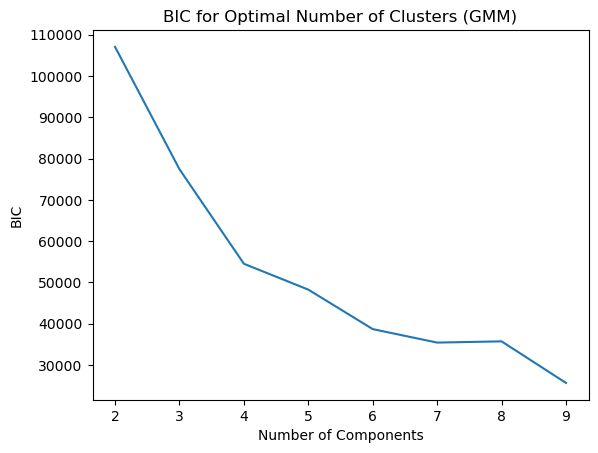

In [333]:
X_gmm = df_no_anomalies.values #np.hstack((df_no_anomalies[numerical_columns].values, encoded_categorical))

# Finding the optimal number of clusters using BIC
bic = []
for n in range(2, 10):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=960)
    gmm.fit(X_gmm)
    bic.append(gmm.bic(X_gmm))

# Plot BIC values to find the optimal number of clusters
plt.plot(range(2, 10), bic)
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('BIC for Optimal Number of Clusters (GMM)')
plt.show()

In [339]:
# Apply GMM with the optimal number of components
df_gmm = df_no_anomalies.copy()
optimal_clusters_gmm = 4
gmm = GaussianMixture(n_components=optimal_clusters_gmm, covariance_type='spherical', random_state=960)
df_gmm['customer_group'] = gmm.fit_predict(X_gmm)

gmm_result_df = pd.concat([df_gmm, anomalies_data], axis=0)
gmm_result_df["customer_group"].value_counts()

customer_group
 3    2552
 0    2394
 1    1927
 2    1692
-1    1379
Name: count, dtype: int64

/var/folders/z6/47hkfr6s6d1_cchpbbsz96k40000gn/T/ipykernel_69170/1934462547.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='complete')


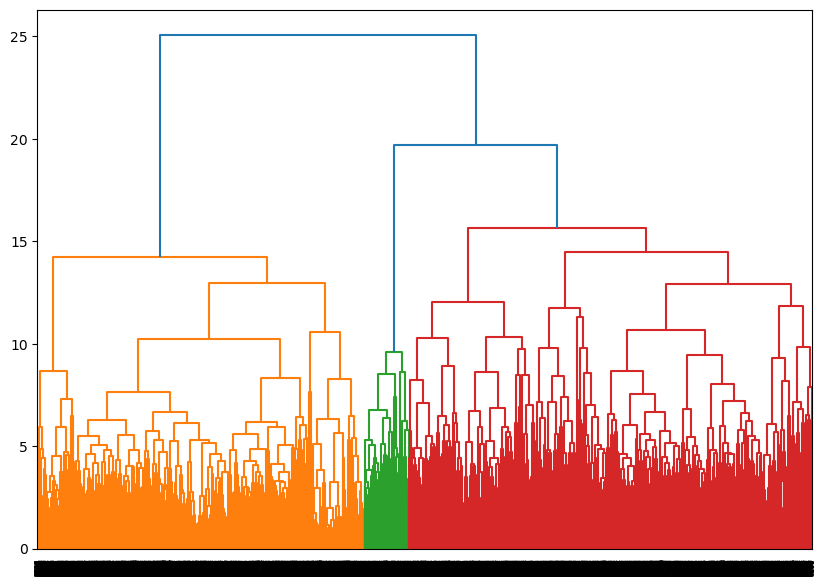

In [364]:
gower_dist = gower.gower_matrix(df_no_anomalies)

# Create a dendrogram to visualize the cluster hierarchy
Z = linkage(gower_dist, method='complete')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()

In [ ]:
gower_dist = gower.gower_matrix(df_no_anomalies)

# Create a dendrogram to visualize the cluster hierarchy
Z = linkage(gower_dist, method='complete')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()

In [366]:
# Choose an optimal number of clusters based on the dendrogram
optimal_clusters_agglo = 3
df_hierarchical = df_no_anomalies.copy()
agglo = AgglomerativeClustering(n_clusters=optimal_clusters_agglo, metric='precomputed', linkage='complete')
df_hierarchical['customer_group'] = agglo.fit_predict(gower_dist)

hierarchical_result_df = pd.concat([df_hierarchical, anomalies_data], axis=0)
hierarchical_result_df["customer_group"].value_counts()

customer_group
 0    3792
 1    3619
-1    1379
 2    1154
Name: count, dtype: int64

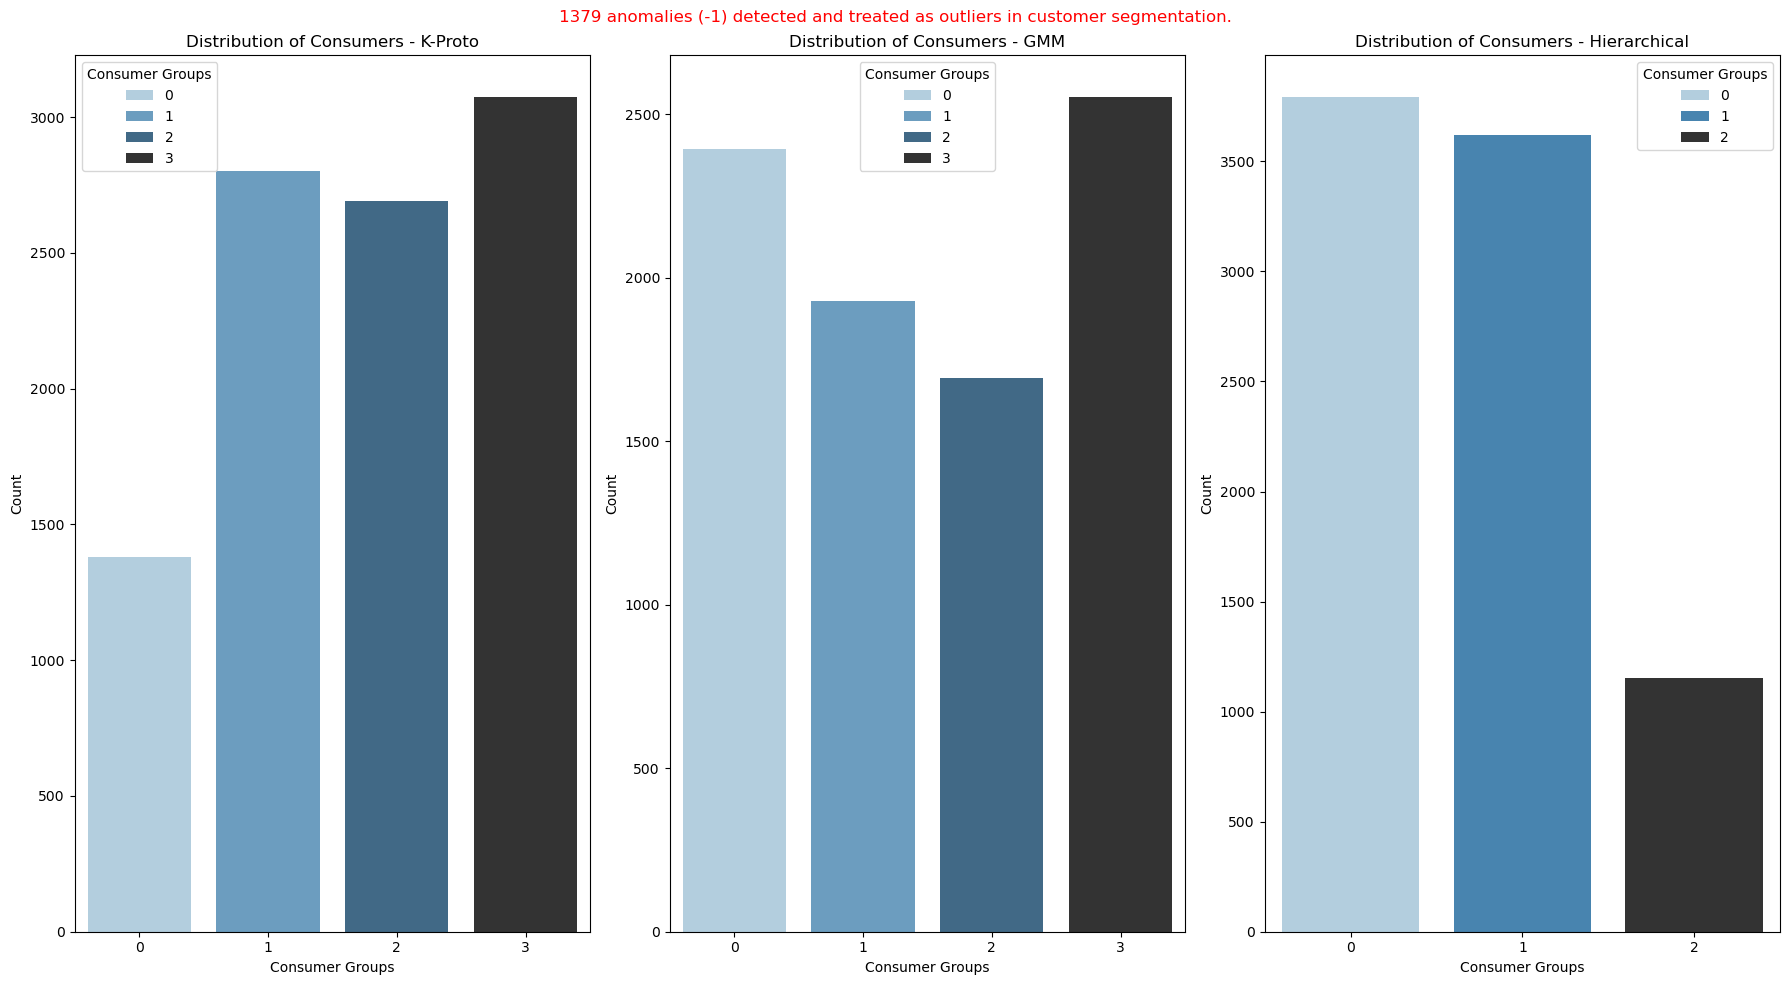

In [382]:
anomaly_count = anomalies_data.shape[0]

# # Filter out anomalies (rows with -1)
# df_no_anomalies = df[df.apply(lambda x: x != -1)]

# Plot 1x3 barplots for each variable excluding -1 (now filtered out)
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Titles for each variable
data_ = [df_kproto, df_gmm, df_hierarchical]
data_names = ["K-Proto","GMM","Hierarchical"]


for i, data in enumerate(data_):
    sns.countplot(x=data["customer_group"], ax=axes[i], hue=data["customer_group"], palette="Blues_d")
    axes[i].set_title(f'Distribution of Consumers - {data_names[i]}')
    axes[i].set_xlabel('Consumer Groups')
    axes[i].set_ylabel('Count')
    axes[i].get_legend().set_title("Consumer Groups")

# Add a note in the figure about anomalies
fig.suptitle(f'{anomaly_count} anomalies (-1) detected and treated as outliers in customer segmentation.', fontsize=12, color='red')

plt.tight_layout()
plt.show()

#### 8.) Visualization of Customer Groups

Used PCA with two components to visualize customer groups.

* PCA reduces the dimensionality of the data while preserving the variance, which is useful for visualizing high-dimensional data. PCA helps capture the primary patterns of variability in the dataset, allowing for a more interpretable visualization of clusters.


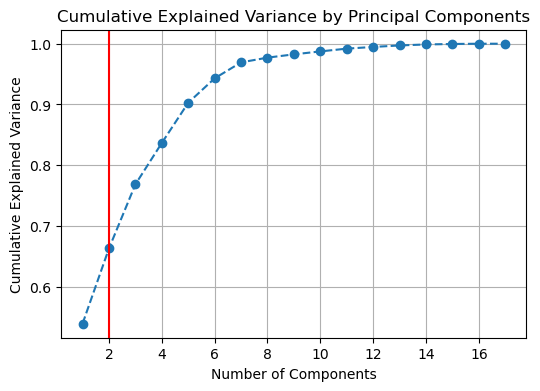

In [560]:
from sklearn.decomposition import PCA

# Perform PCA on the numerical features of df_kproto
pca = PCA()

pca.fit(df_kproto.iloc[:,:-1])
explained_variance = pca.explained_variance_ratio_

# Plot the cumulative explained variance to decide the optimal number of components
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.axvline(x = 2, color = 'r', label = 'Total variance by first 2 Principa Components')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [564]:
df_kproto.iloc[:,:-1]

,gender,has_gender,has_dob,app_downloads,ctr,redemption_rate,unique_offer_ctr,log_customer_age,log_account_age,log_total_offer_clicks,log_account_last_updated,log_total_offer_impressions,log_total_offers_redeemed,log_unique_offer_clicked,log_unique_offer_impressions,demographic_cluster,redemption_cluster
0,1.0,0.0,0.0,1.0,0.057692,0.333333,0.375,0.201078,0.058651,0.200913,0.074052,0.453215,0.000000,0.344010,0.586397,1,0
1,1.0,0.0,0.0,1.0,0.137931,0.125,0.6,0.201078,0.046457,0.435966,0.074052,0.470141,0.000000,0.344010,0.428317,1,0
2,1.0,0.0,0.0,1.0,0.021858,0.75,0.333333,0.201078,0.058651,0.265592,0.074052,0.649648,0.386853,0.344010,0.627474,1,0
3,1.0,0.0,0.0,1.0,0.125,0.142857,0.75,0.201078,0.042349,0.401826,0.074052,0.464698,0.000000,0.344010,0.357235,1,0
4,0.0,1.0,1.0,1.0,0.072289,0.5,0.571429,0.180111,0.903911,0.363121,0.000000,0.525897,0.386853,0.454757,0.540476,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9607,1.0,0.0,0.0,1.0,0.033708,0.333333,0.222222,0.201078,0.062673,0.200913,0.074052,0.536785,0.000000,0.201233,0.627474,1,0
9608,1.0,1.0,1.0,1.0,0.066007,0.15,0.421053,0.085290,0.078550,0.681561,0.074052,0.728889,0.386853,0.746476,0.897712,0,0
9609,0.0,1.0,0.0,1.0,0.025316,0.5,0.071429,0.189396,0.556031,0.117527,0.074052,0.518196,0.000000,0.000000,0.785553,0,0
9610,1.0,0.0,0.0,1.0,0.106383,0.4,0.666667,0.201078,0.231121,0.318439,0.074052,0.437577,0.226294,0.454757,0.488416,1,0


In [404]:
pca_to_visualize = PCA(n_components=2)
principal_component_values = pca_to_visualize.fit_transform(df_kproto.iloc[:,:-1])
principal_component_values.shape

(9944, 2)

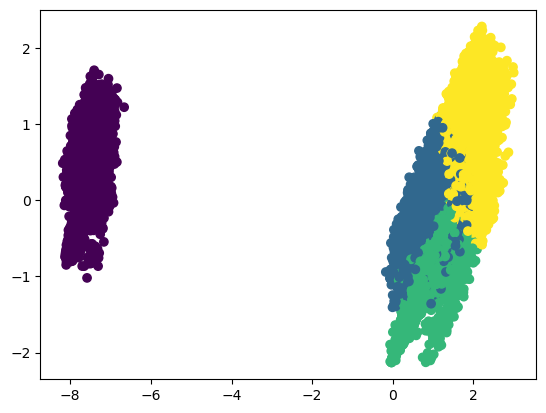

In [423]:
plt.scatter(x=principal_component_values[:,0], y=principal_component_values[:,1], c=df_kproto.iloc[:,-1])
plt.show()

#### 9.) Results
In this PCA visualization of customer groups, we can observe that **nearly 65%** of the variance is explained by the **first two principal components**. Although the visualization may not represent the exact data structure, the following key insights can be drawn:

**Separation of Anomalies:** Anomalies are clearly separated and placed far from the main clusters of customers. This indicates that the anomaly detection process effectively identified data points that deviate significantly from typical customer behavior.

**Distinct Customer Segments:** The majority of the customers are grouped into distinct clusters with minimal overlap. This suggests that the clustering process (K-Prototypes, GMM, or hierarchical clustering) has effectively captured the natural groupings in the data.

**Minimal Overlapping:** The minimal overlap between the clusters suggests that each customer group has unique characteristics, which can be useful for targeted business strategies.